In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json
import optuna

/opt/anaconda3/envs/hivae/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

control_bis, treated_bis, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

# control = control.drop(columns='treatment')
# treated = treated.drop(columns='treatment')

In [3]:
# control.head()

In [4]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control_bis['censor']), 
                                                                                          np.mean(treated_bis['censor'])))

percent of uncensored data in control set 0.840 and in treated set 0.843


## Save data

In [5]:
dataset_name = "Simulations_4"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

# control.to_csv(data_file_control, index=False, header=False)
# types.to_csv(feat_types_file_control)
# treated.to_csv(data_file_treated, index=False, header=False)
# types.to_csv(feat_types_file_treated)

## Load data

In [6]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [9]:
# Parameters of the optuna study

# metric_optuna = "log_rank_test" # metric to optimize in optuna
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect))

In [10]:
# # the datasets used for training is data_init_control
# T_surv = torch.Tensor(df_init_control.time)
# T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
# n_intervals = 10
# T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
# T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
# intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

### Load best params and optuna study

In [11]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

original_dir = os.getcwd()

metric_optuna = "log_rank_test"
best_params_dict_logrank, study_dict_longrank = {}, {}
for generator_name in generators_sel:
    n_trials = 150
    study_name_cluster = "/home/pchassat/HI-VAE_Pytorch/dataset/Simulations_4/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    study_name = "dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    best_params_file = "dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    db_file = study_name + ".db"
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name=study_name_cluster, storage="sqlite:///{}".format(db_file))
        study_dict_longrank[generator_name] = study
        with open(best_params_file, "r") as f:
            best_params_dict_logrank[generator_name] = json.load(f)
    else:
        raise FileNotFoundError("The optuna study does not exist. Please create it first.")


metric_optuna = "survival_km_distance"
best_params_dict_survkm, study_dict_survkm = {}, {}
for generator_name in generators_sel:
    n_trials = 150
    study_name_cluster = "/home/pchassat/HI-VAE_Pytorch/dataset/Simulations_4/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    study_name = "dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    best_params_file = "dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    db_file = study_name + ".db"
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name=study_name_cluster, storage="sqlite:///{}".format(db_file))
        study_dict_survkm[generator_name] = study
        with open(best_params_file, "r") as f:
            best_params_dict_survkm[generator_name] = json.load(f)
    else:
        raise FileNotFoundError("The optuna study does not exist. Please create it first.")
    

This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


In [12]:
print("Best parameters for HI-VAE Weibull:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_weibull"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_weibull"]))
print('\n')
print("Best parameters for HI-VAE Piecewise:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_piecewise"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_piecewise"]))
print('\n')
print("Best parameters for Surv-GAN:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-GAN"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-GAN"]))
print('\n')
print("Best parameters for Surv-VAE:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-VAE"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-VAE"])) 

Best parameters for HI-VAE Weibull:
 - with survival_km_distance: {'lr': 0.0002, 'batch_size': 60, 'z_dim': 5, 'y_dim': 15, 's_dim': 20}
 - with log_rank_test: {'lr': 0.001, 'batch_size': 60, 'z_dim': 10, 'y_dim': 25, 's_dim': 15}


Best parameters for HI-VAE Piecewise:
 - with survival_km_distance: {'lr': 0.0002, 'batch_size': 60, 'z_dim': 30, 'y_dim': 25, 's_dim': 15, 'n_layers_surv_piecewise': 1, 'n_intervals': 5}
 - with log_rank_test: {'lr': 0.001, 'batch_size': 96, 'z_dim': 5, 'y_dim': 5, 's_dim': 10, 'n_layers_surv_piecewise': 1, 'n_intervals': 5}


Best parameters for Surv-GAN:
 - with survival_km_distance: {'generator_n_layers_hidden': 1, 'generator_n_units_hidden': 50, 'generator_nonlin': 'elu', 'generator_dropout': 0.11861126837730548, 'discriminator_n_layers_hidden': 3, 'discriminator_n_units_hidden': 150, 'discriminator_nonlin': 'relu', 'discriminator_dropout': 0.029732934912357126, 'lr': 0.001, 'weight_decay': 0.0001, 'encoder_max_clusters': 19}
 - with log_rank_test: {'g

In [13]:
# best_params_hivae_weibull = best_params_dict["HI-VAE_weibull"]
# best_params_hivae_piecewise = best_params_dict["HI-VAE_piecewise"]
# best_params_survgan = best_params_dict["Surv-GAN"]
# best_params_survae = best_params_dict["Surv-VAE"]

print("Best parameters for HI-VAE Weibull:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_weibull"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_weibull"]))
print('\n')
print("Best parameters for HI-VAE Piecewise:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_piecewise"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_piecewise"]))
print('\n')
print("Best parameters for Surv-GAN:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-GAN"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-GAN"]))
print('\n')
print("Best parameters for Surv-VAE:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-VAE"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-VAE"])) 

Best parameters for HI-VAE Weibull:
 - with survival_km_distance: {'lr': 0.0002, 'batch_size': 60, 'z_dim': 5, 'y_dim': 15, 's_dim': 20}
 - with log_rank_test: {'lr': 0.001, 'batch_size': 60, 'z_dim': 10, 'y_dim': 25, 's_dim': 15}


Best parameters for HI-VAE Piecewise:
 - with survival_km_distance: {'lr': 0.0002, 'batch_size': 60, 'z_dim': 30, 'y_dim': 25, 's_dim': 15, 'n_layers_surv_piecewise': 1, 'n_intervals': 5}
 - with log_rank_test: {'lr': 0.001, 'batch_size': 96, 'z_dim': 5, 'y_dim': 5, 's_dim': 10, 'n_layers_surv_piecewise': 1, 'n_intervals': 5}


Best parameters for Surv-GAN:
 - with survival_km_distance: {'generator_n_layers_hidden': 1, 'generator_n_units_hidden': 50, 'generator_nonlin': 'elu', 'generator_dropout': 0.11861126837730548, 'discriminator_n_layers_hidden': 3, 'discriminator_n_units_hidden': 150, 'discriminator_nonlin': 'relu', 'discriminator_dropout': 0.029732934912357126, 'lr': 0.001, 'weight_decay': 0.0001, 'encoder_max_clusters': 19}
 - with log_rank_test: {'g

In [14]:
# Visualize the results of the optuna study

from optuna.visualization import plot_slice
from optuna.visualization import plot_optimization_history

print('---------------------- surv_km distance ----------------------')
fig = plot_slice(study_dict_survkm["HI-VAE_weibull"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["HI-VAE_weibull"])
fig.show()

---------------------- surv_km distance ----------------------


In [15]:
trial = study_dict_survkm["HI-VAE_weibull"].trials[72]
print(trial.params)

{'lr': 0.0002, 'batch_size': 60, 'z_dim': 5, 'y_dim': 15, 's_dim': 20}


In [16]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate, plot_contour

# Visualize the optimization history
plot_optimization_history(study_dict_survkm["HI-VAE_weibull"]).show()
plot_param_importances(study_dict_survkm["HI-VAE_weibull"]).show()
plot_slice(study_dict_survkm["HI-VAE_weibull"]).show()
plot_parallel_coordinate(study_dict_survkm["HI-VAE_weibull"]).show()
plot_contour(study_dict_survkm["HI-VAE_weibull"]).show()

In [17]:
print('----------------------  log rank test ----------------------')
fig = plot_slice(study_dict_longrank["HI-VAE_weibull"])
fig.show()

fig = plot_optimization_history(study_dict_longrank["HI-VAE_weibull"])
fig.show()

----------------------  log rank test ----------------------


In [18]:
# print('----------------------  log rank test ----------------------')
# fig = plot_slice(study_dict_survkm["Surv-GAN"])
# fig.show()

# fig = plot_optimization_history(study_dict_survkm["Surv-GAN"])
# fig.show()

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [17]:
# the datasets used for training is data_init_control
n_generated_dataset = 50
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset, epochs=10000)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0855, ELBO_train: -15.32467222, KL_z: 1.72837490, KL_s: 0.07078397, reconstruction loss: -13.52551335
Epoch: [100]  time: 1.0534, ELBO_train: -12.05270767, KL_z: 0.82128075, KL_s: 0.04007471, reconstruction loss: -11.19135222
Epoch: [200]  time: 2.0372, ELBO_train: -11.98012733, KL_z: 1.11522096, KL_s: 0.03226030, reconstruction loss: -10.83264607
Epoch: [300]  time: 2.9216, ELBO_train: -11.85344744, KL_z: 1.27773511, KL_s: 0.03136051, reconstruction loss: -10.54435182
Epoch: [400]  time: 3.8392, ELBO_train: -11.56897306, KL_z: 1.36914766, KL_s: 0.03276956, reconstruction loss: -10.16705585
Epoch: [500]  time: 4.7596, ELBO_train: -11.70520449, KL_z: 1.54674077, KL_s: 0.04216969, reconstruction loss: -10.11629403
Epoch: [600]  time: 5.6538, ELBO_train: -11.51248837, KL_z: 1.62565464, KL_s: 0.04162204, reconstruction loss: -9.84521168
Epoch: [700]  time: 6.5750, ELBO_train: -11.52663374, KL_z: 1.68022931, KL_s: 0.04063630, reconstructi

[2025-06-23T13:42:41.409897+0200][54243][CRITICAL] Error importing TabularGoggle: No module named 'dgl'
[2025-06-23T13:42:41.411444+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:42:42.415307+0200][54243][CRITICAL] load failed: No module named 'pytorch_lightning'
[2025-06-23T13:42:42.415843+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:42:42.416016+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:42:42.621694+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:42:42.622572+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:42:42.622883+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_

{'fitted': False, 'module_relative_path': PosixPath('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': PosixPath('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  7%|▋         | 699/10000 [00:19<04:25, 35.01it/s]
[2025-06-23T13:43:06.260555+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:43:06.261283+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:43:06.261504+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:43:06.261700+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:43:06.283071+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:43:06.283499+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:43:06.283684+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


 60%|██████    | 600/1000 [00:30<00:20, 19.81it/s]


### Run with best params surv_km_dist

In [ ]:
metric_optuna = 'survival_km_distance'

'survival_km_distance'

In [19]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_survkm = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_survkm[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run_CV(df_init_control_encoded,
                                                                                        miss_mask_control, 
                                                                                        true_miss_mask_control,
                                                                                        feat_types_dict_ext, 
                                                                                        n_generated_dataset, 
                                                                                        n_splits=5,
                                                                                        n_trials=n_trials, 
                                                                                        columns=fnames,
                                                                                        generator_name=generator_name,
                                                                                        epochs=10000,
                                                                                        metric=metric_optuna,
                                                                                        study_name='',
                                                                                        params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.1647, ELBO_train: -13.92936738, KL_z: 0.60432837, KL_s: 0.07268580, reconstruction loss: -13.25235321
Epoch: [100]  time: 1.9223, ELBO_train: -13.16506767, KL_z: 0.26515566, KL_s: 0.04338749, reconstruction loss: -12.85652452
Epoch: [200]  time: 3.1317, ELBO_train: -12.91150506, KL_z: 0.32928251, KL_s: 0.03323531, reconstruction loss: -12.54898724
Epoch: [300]  time: 4.3953, ELBO_train: -12.73100344, KL_z: 0.49128494, KL_s: 0.03182642, reconstruction loss: -12.20789209
Epoch: [400]  time: 5.6400, ELBO_train: -12.44339752, KL_z: 0.64120336, KL_s: 0.03119842, reconstruction loss: -11.77099574
Epoch: [500]  time: 6.9437, ELBO_train: -12.63374138, KL_z: 0.73176195, KL_s: 0.03026994, reconstruction loss: -11.87170949
Epoch: [600]  time: 8.1762, ELBO_train: -12.12724940, KL_z: 0.80959481, KL_s: 0.03047673, reconstruction loss: -11.28717786
Epoch: [700]  time: 9.5849, ELBO_train: -12.09535917, KL_z: 0.90858455, KL_s: 0.02976529, reconstruct

KeyboardInterrupt: 

In [18]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_survkm = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_survkm[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params, 
                                                                                                epochs = 10000)
    else:
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0319, ELBO_train: -13.86761999, KL_z: 0.60013364, KL_s: 0.07143885, reconstruction loss: -13.19604750
Epoch: [100]  time: 1.9503, ELBO_train: -13.04204512, KL_z: 0.27397018, KL_s: 0.03882712, reconstruction loss: -12.72924782
Epoch: [200]  time: 3.8567, ELBO_train: -12.88674045, KL_z: 0.45784041, KL_s: 0.03350008, reconstruction loss: -12.39539996
Epoch: [300]  time: 5.7086, ELBO_train: -12.52795601, KL_z: 0.61437652, KL_s: 0.03266746, reconstruction loss: -11.88091204
Epoch: [400]  time: 7.7491, ELBO_train: -12.36149621, KL_z: 0.79851349, KL_s: 0.03174871, reconstruction loss: -11.53123401
Epoch: [500]  time: 9.7619, ELBO_train: -12.15381670, KL_z: 0.91504423, KL_s: 0.03178877, reconstruction loss: -11.20698370
Epoch: [600]  time: 11.6831, ELBO_train: -12.20239234, KL_z: 1.01440620, KL_s: 0.03111422, reconstruction loss: -11.15687191
Epoch: [700]  time: 13.5422, ELBO_train: -11.84910512, KL_z: 1.11389765, KL_s: 0.03065777, reconstru

[2025-06-23T13:45:00.979415+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:45:00.980434+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:00.980731+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:00.980952+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:45:01.051564+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:45:01.052125+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:01.052433+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:01.052760+0200]

Early stopping at epoch 1250.
Training finished.
Generate data by Surv-GAN


  7%|▋         | 749/10000 [00:15<03:05, 49.89it/s]
[2025-06-23T13:45:20.694393+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:45:20.696305+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:20.696820+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:20.697070+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:45:20.722949+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:45:20.723863+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:45:20.724608+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


100%|██████████| 100/100 [00:00<00:00, 112.94it/s]


### Run with best params logrank

In [19]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_logrank = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_logrank[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_logrank[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params,
                                                                                                epochs=10000)
    else:
        data_gen_control_dict_best_params_logrank[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0297, ELBO_train: -14.88752627, KL_z: 1.25023299, KL_s: 0.06470942, reconstruction loss: -13.57258385
Epoch: [100]  time: 2.2721, ELBO_train: -11.81996202, KL_z: 1.17549694, KL_s: 0.06821775, reconstruction loss: -10.57624733
Epoch: [200]  time: 4.7067, ELBO_train: -11.79845023, KL_z: 1.58467105, KL_s: 0.05155665, reconstruction loss: -10.16222253
Epoch: [300]  time: 7.0178, ELBO_train: -11.44539475, KL_z: 1.86070341, KL_s: 0.04934025, reconstruction loss: -9.53535110
Epoch: [400]  time: 9.3202, ELBO_train: -11.33823967, KL_z: 1.97012076, KL_s: 0.05407411, reconstruction loss: -9.31404480
Epoch: [500]  time: 11.7511, ELBO_train: -11.50390673, KL_z: 2.04749763, KL_s: 0.05537176, reconstruction loss: -9.40103734
Epoch: [600]  time: 14.3442, ELBO_train: -11.67919731, KL_z: 2.12897325, KL_s: 0.05545032, reconstruction loss: -9.49477375
Epoch: [700]  time: 16.8865, ELBO_train: -11.19822335, KL_z: 2.19868499, KL_s: 0.05523747, reconstructi

[2025-06-23T13:46:32.084876+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:46:32.098216+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:32.098932+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:32.099348+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:46:32.221267+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:46:32.222116+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:32.222518+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:32.222843+0200]

Early stopping at epoch 1750.
Training finished.
Generate data by Surv-GAN


  4%|▍         | 399/10000 [00:06<02:27, 65.14it/s]
[2025-06-23T13:46:43.505009+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:46:43.506639+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:43.507190+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:43.507628+0200][54243][CRITICAL] module plugin_decaf load failed
[2025-06-23T13:46:43.545036+0200][54243][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-23T13:46:43.545848+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-23T13:46:43.546319+0200][54243][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


100%|██████████| 100/100 [00:01<00:00, 58.11it/s]


### Plot survival curves

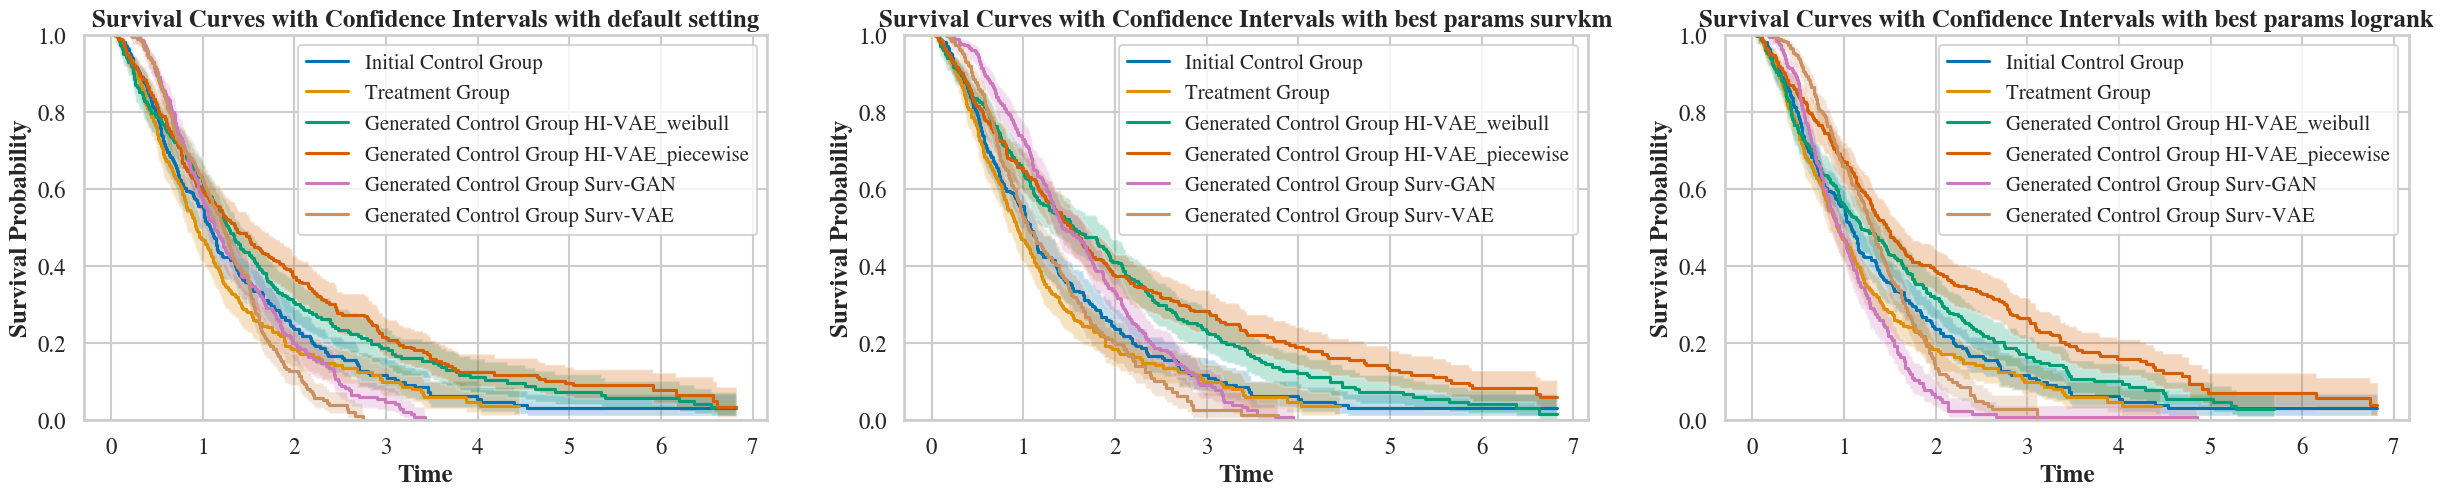

In [21]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 3, figsize=(30, 5))

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")


kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params survkm", fontweight="bold")


kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[2])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[2])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params_logrank[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[2])
axs[2].set_ylim(0, 1)
axs[2].legend(fontsize=15)
axs[2].set_xlabel("Time", fontweight="semibold")
axs[2].set_ylabel("Survival Probability", fontweight="semibold")
axs[2].set_title("Survival Curves with Confidence Intervals with best params logrank", fontweight="bold")

plt.show()

In [20]:
# Convert generated data into dataframe
df_gen_control_dict_best_params_survkm = {}
df_gen_control_dict_best_params_logrank = {}
df_gen_control_dict_default = {}
df_syn_dict_best_params_survkm = {}
df_syn_dict_best_params_logrank = {}
df_syn_dict_default = {}
for generator_name in generators_sel:
    list_df_gen_control_best_params_survkm = []
    list_df_gen_control_best_params_logrank = []
    list_df_gen_control_default = []
    data_syn_best_params_survkm = []
    data_syn_best_params_logrank = []
    data_syn_default = []
    for j in range(n_generated_dataset):
        df_gen_survkm_control_j = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][j].numpy(), columns=fnames)
        df_gen_survkm_control_j['treatment'] = 0
        list_df_gen_control_best_params_survkm.append(df_gen_survkm_control_j)
        data_syn_best_params_survkm.append(pd.concat([df_init_treated, df_gen_survkm_control_j], ignore_index=True))

        df_gen_logrank_control_j = pd.DataFrame(data_gen_control_dict_best_params_logrank[generator_name][j].numpy(), columns=fnames)
        df_gen_logrank_control_j['treatment'] = 0
        list_df_gen_control_best_params_logrank.append(df_gen_logrank_control_j)
        data_syn_best_params_logrank.append(pd.concat([df_init_treated, df_gen_logrank_control_j], ignore_index=True))

        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control_default.append(df_gen_control_j)
        data_syn_default.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict_best_params_survkm[generator_name] = list_df_gen_control_best_params_survkm
    df_gen_control_dict_best_params_logrank[generator_name] = list_df_gen_control_best_params_logrank
    df_gen_control_dict_default[generator_name] = list_df_gen_control_default
    df_syn_dict_best_params_survkm[generator_name] = data_syn_best_params_survkm
    df_syn_dict_best_params_logrank[generator_name] = data_syn_best_params_logrank
    df_syn_dict_default[generator_name] = data_syn_default

### 3. Compare generation performance

#### 3.1. General metrics

In [21]:
from utils.metrics import general_metrics
general_scores_survkm = []
general_scores_default = []
general_scores_logrank = []
for generator_name in generators_sel:
    general_scores_survkm.append(general_metrics(df_init_control, df_gen_control_dict_best_params_survkm[generator_name], generator_name))
    general_scores_default.append(general_metrics(df_init_control, df_gen_control_dict_default[generator_name], generator_name))
    general_scores_logrank.append(general_metrics(df_init_control, df_gen_control_dict_best_params_logrank[generator_name], generator_name))
general_scores_default_df = pd.concat(general_scores_default)
general_scores_survkm_df = pd.concat(general_scores_survkm)
general_scores_logrank_df = pd.concat(general_scores_logrank)

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

##### 3.1.1. Data resemblance

===================== General performance with best params survkm: =====================


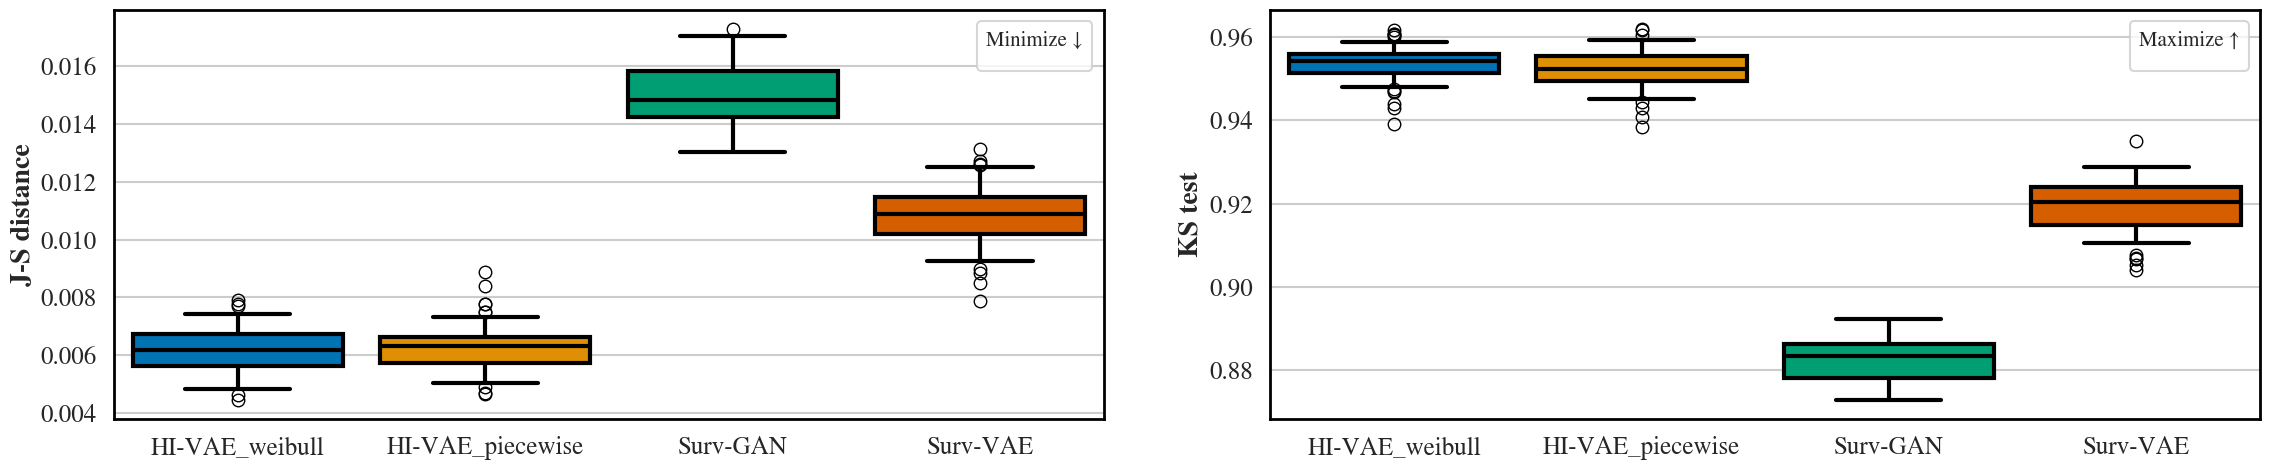

===================== General performance with best params logrank: =====================


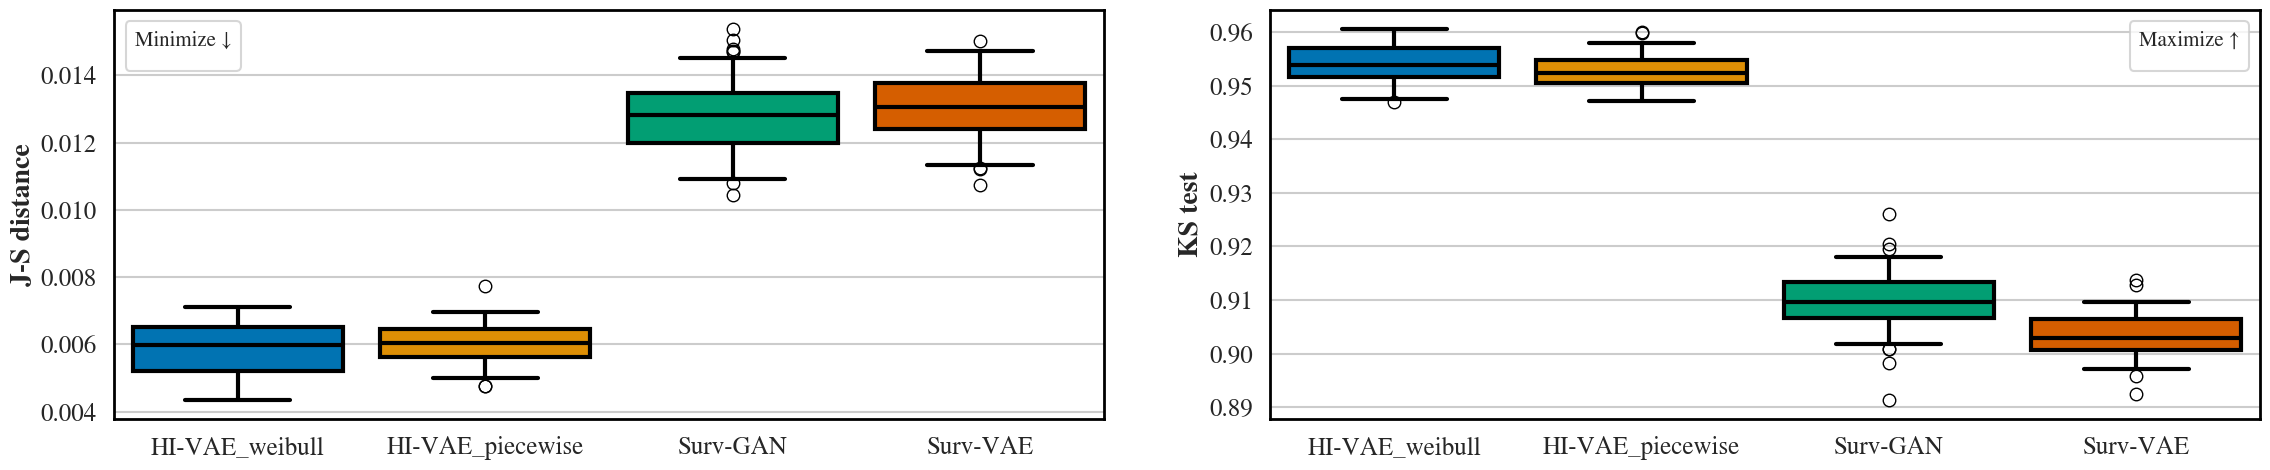

===================== General performance with default params: =====================


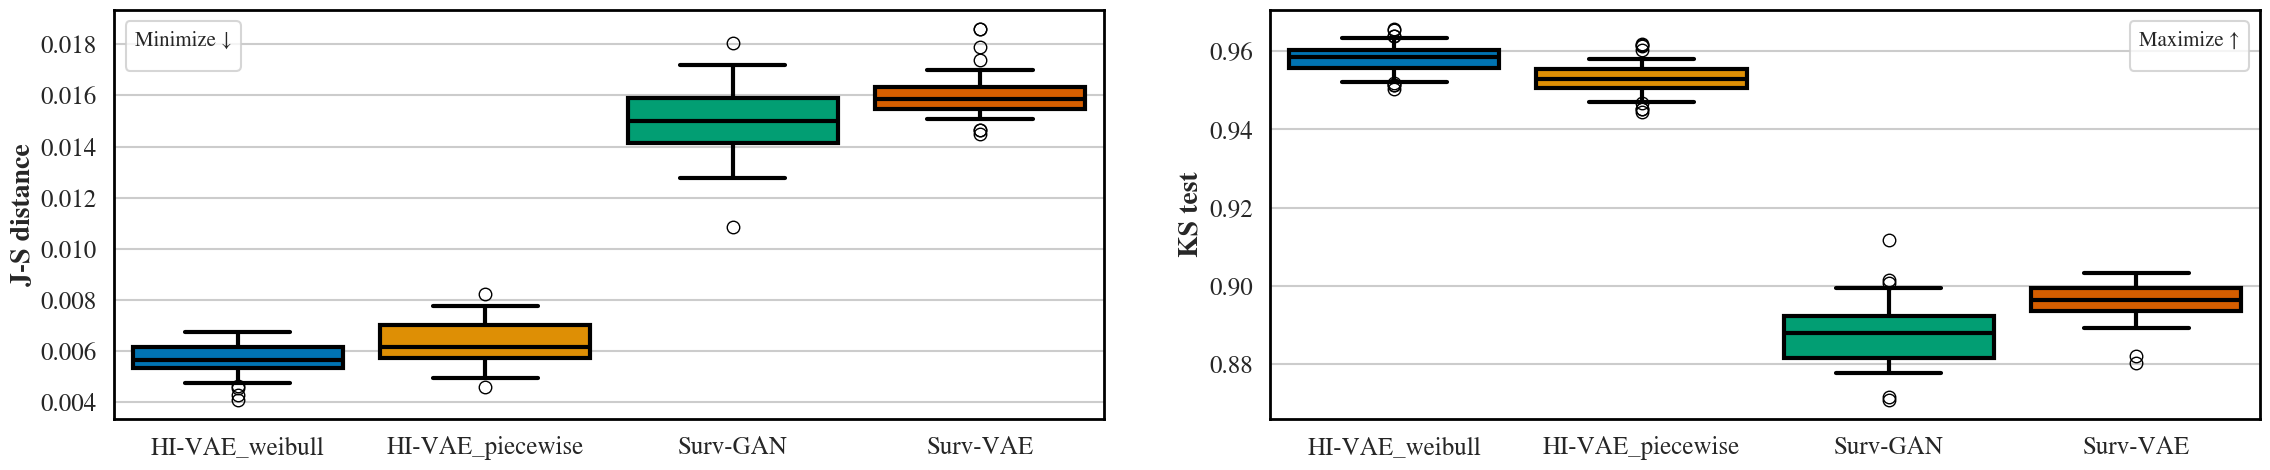

In [22]:
from utils.visualization import visualize_general_perf
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

===================== General performance with best params survkm: =====================


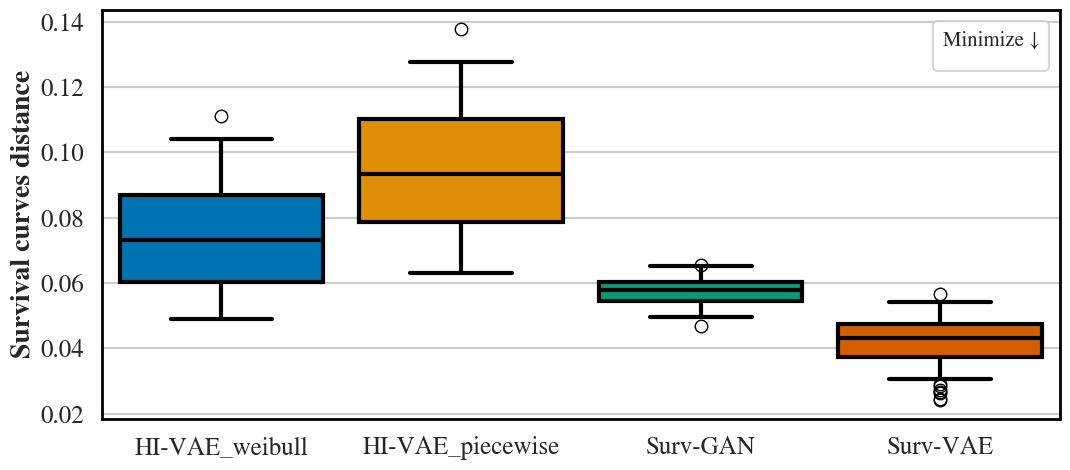

===================== General performance with best params logrank: =====================


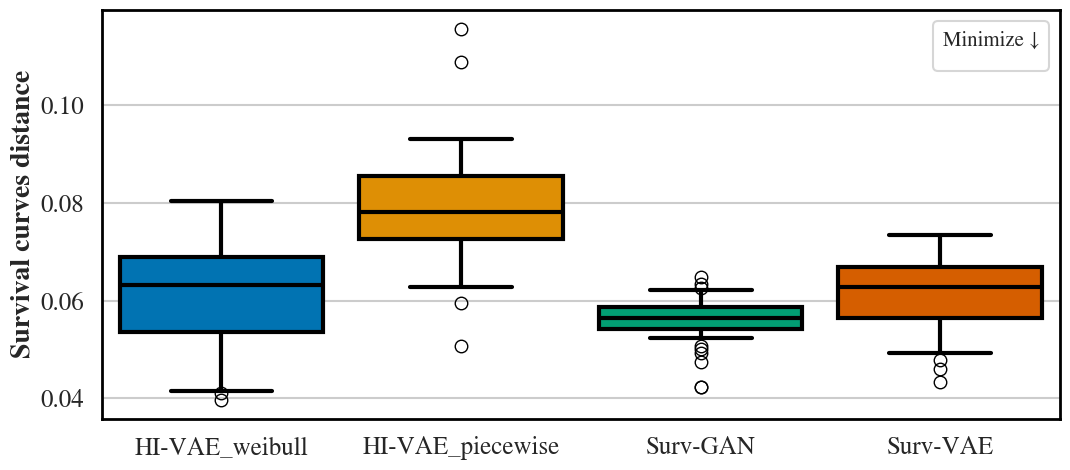

===================== General performance with default params: =====================


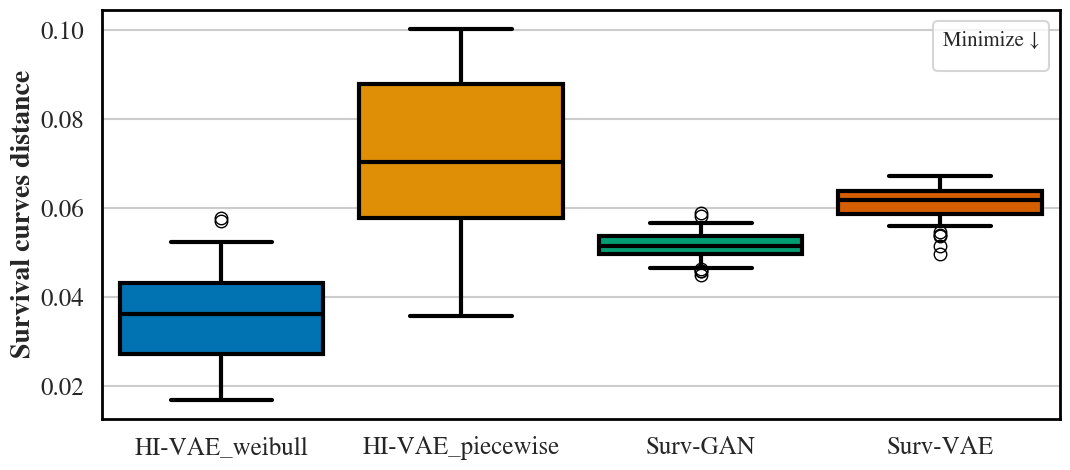

In [23]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['Survival curves distance', "min"]]) #, ['Detection XGB', "min"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['Survival curves distance', "min"]]) #, ['Detection XGB', "min"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['Survival curves distance', "min"]]) #, ['Detection XGB', "min"]])

#### 3.1.3. Privacy

===================== General performance with best params survkm: =====================


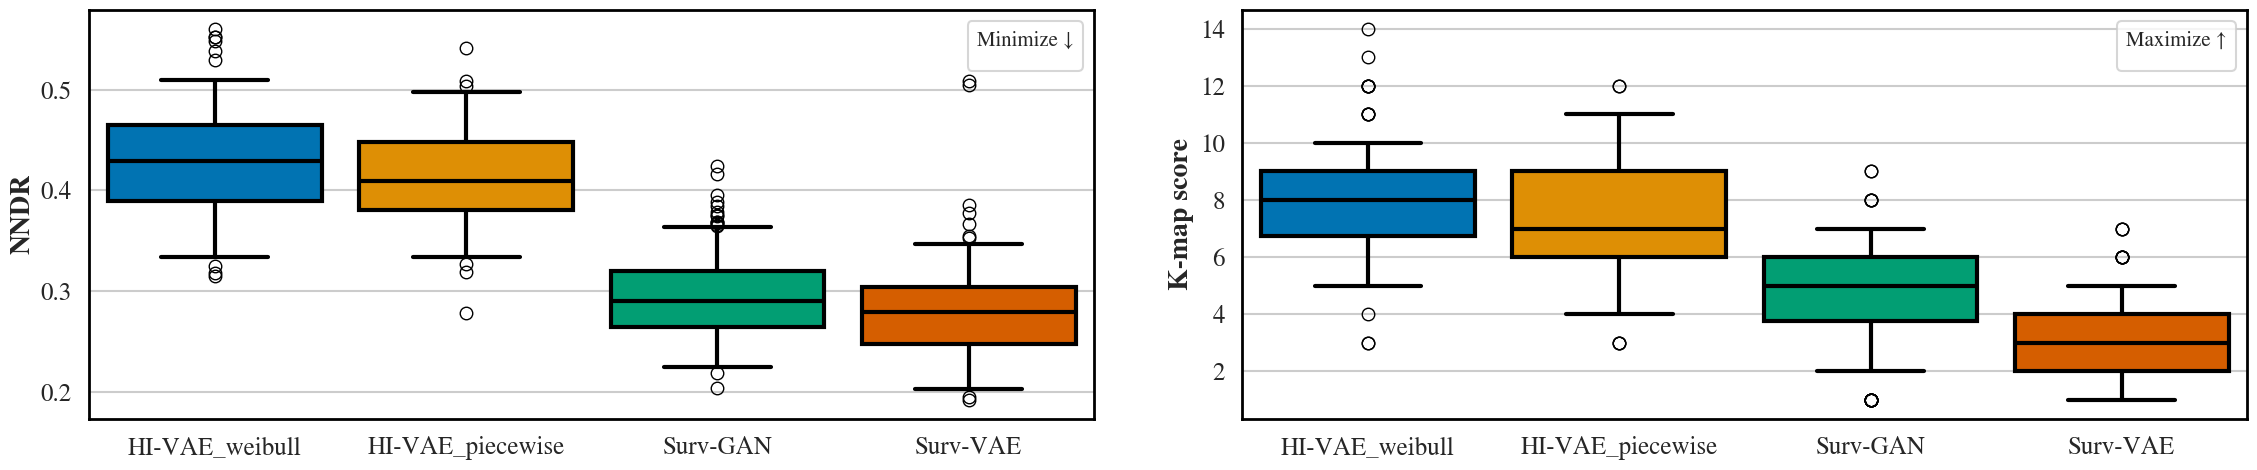

===================== General performance with best params logrank: =====================


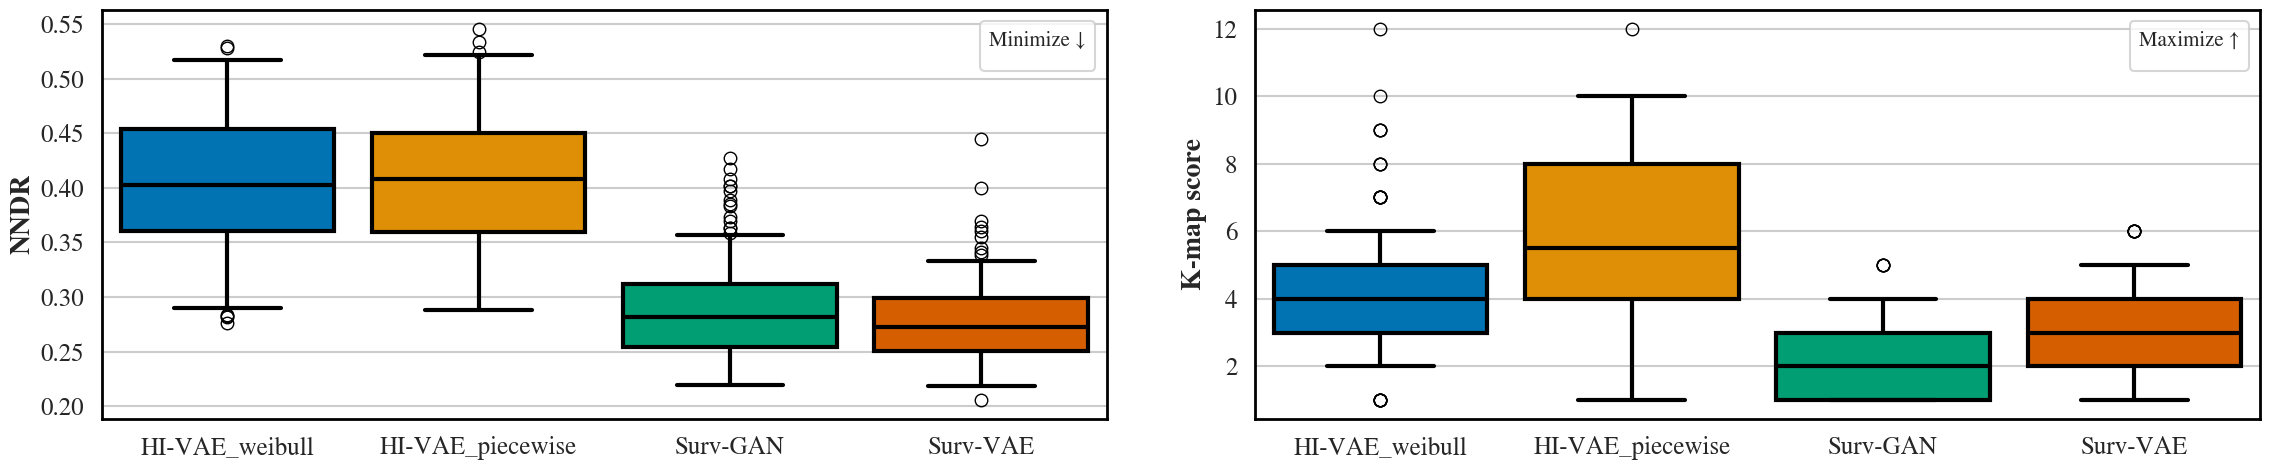

===================== General performance with default params: =====================


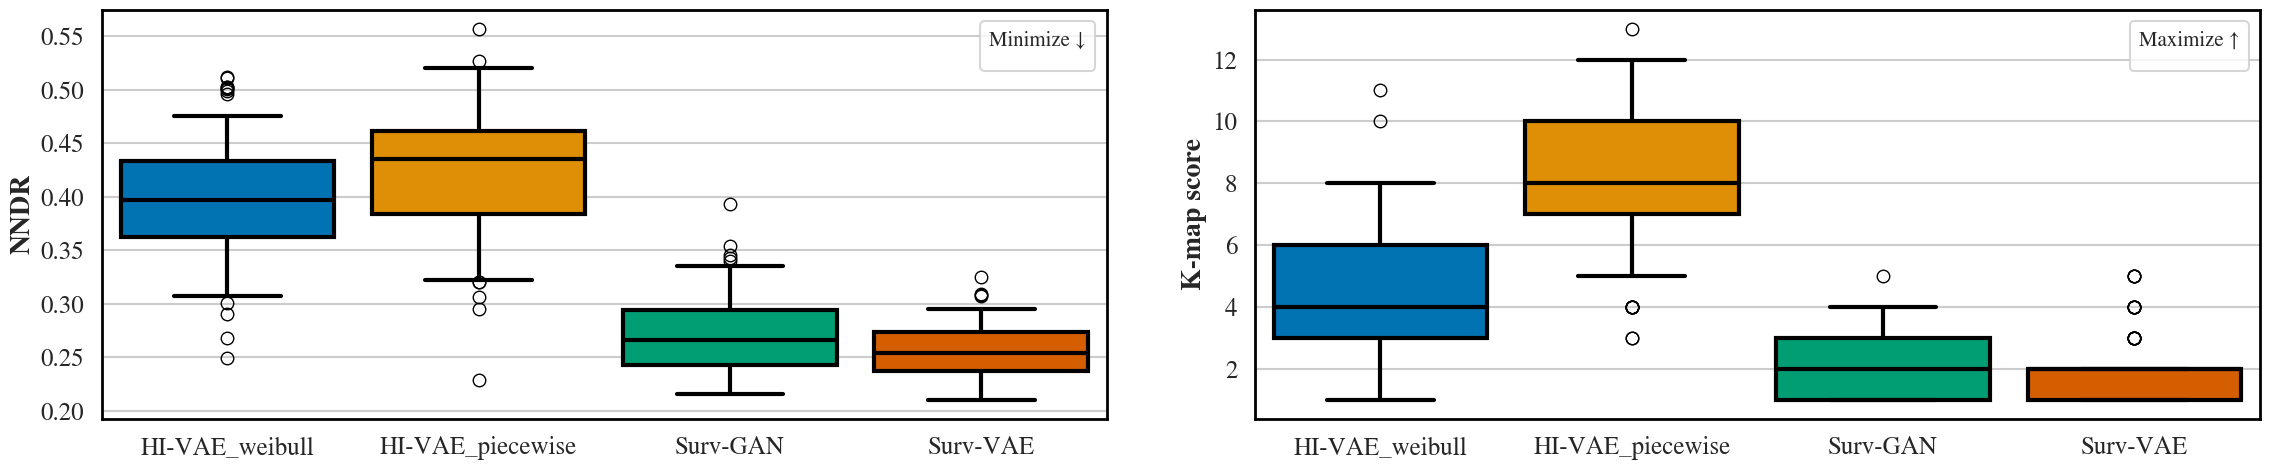

In [26]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics with best params

In [27]:
# choose the type of best parameters to use
df_syn_dict_best_params = df_syn_dict_best_params_logrank.copy()

In [28]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict_best_params[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

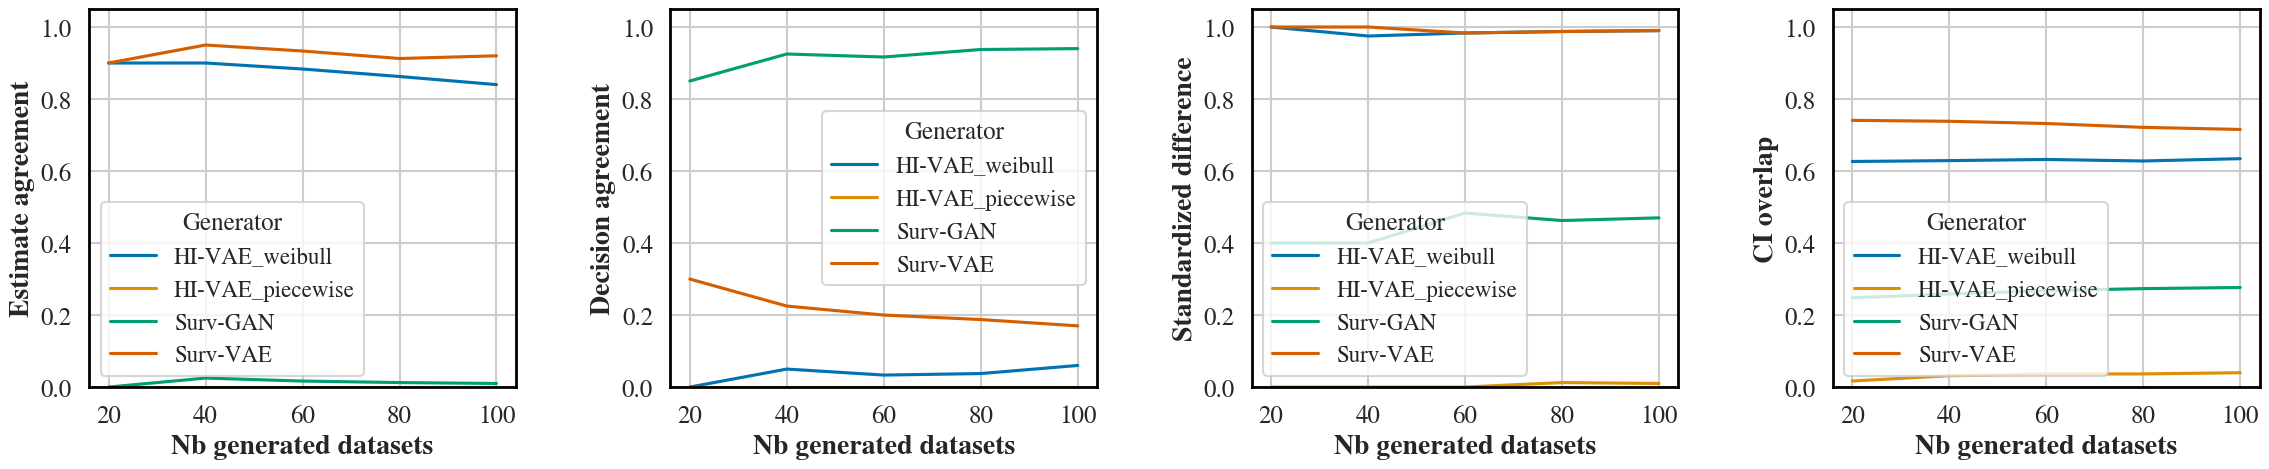

In [29]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [30]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict_best_params[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

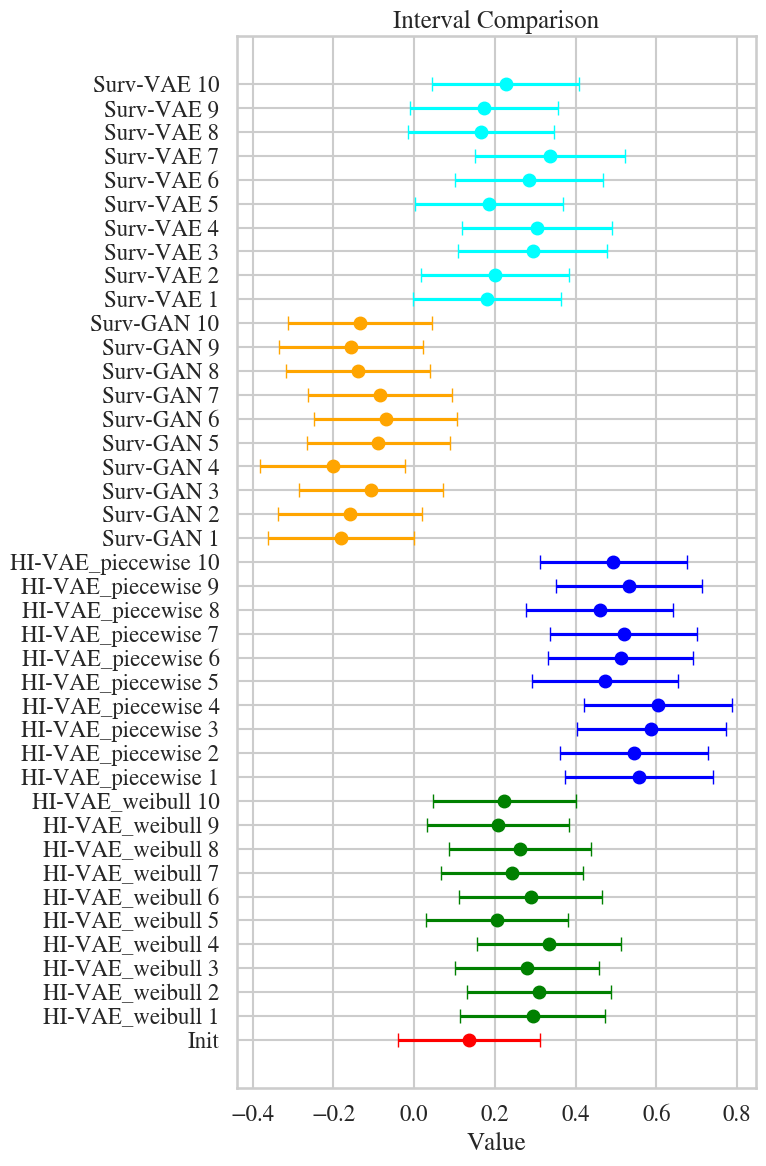

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()